In [1]:
# pip install PyPortfolioOpt
# pip install cvxpy
# pip install cvxopt

In [1]:
#Import the python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [48]:
#Get the stock tickers in the portfolio 
assets = ['AMD','NFLX','AAPL','GOOG', 'SPY']

In [49]:
#Assign weights to the stocks. 
weights = np.array([0.25]*len(assets))

In [50]:
# Get the stock/ portfolio starting date
stockStartDate = '2015-01-01'

In [51]:
today = datetime.today().strftime('%Y-%m-%d')
today

'2021-08-15'

In [52]:
# Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

# Store the adjusted close price of the sock into the df
for stock in assets:
  df[stock] = web.DataReader(stock,data_source='yahoo',start=stockStartDate,end=today)['Adj Close']

In [53]:
df.head()

,AMD,NFLX,AAPL,GOOG,SPY
Date,,,,,
2015-01-02,2.67,49.848572,24.782110,523.373108,181.556000
2015-01-05,2.66,47.311428,24.083958,512.463013,178.277176
2015-01-06,2.63,46.501431,24.086227,500.585632,176.598022
2015-01-07,2.58,46.742859,24.423975,499.727997,178.798615
2015-01-08,2.61,47.779999,25.362394,501.303680,181.971420


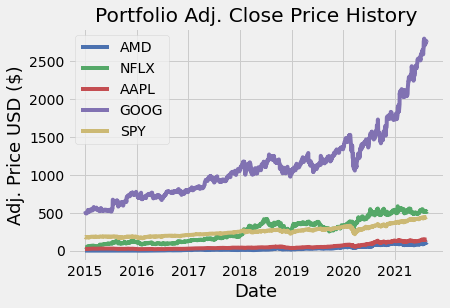

In [54]:
# Visually show the stock/ portfolio
title = 'Portfolio Adj. Close Price History'

# Get the stocks
my_stocks = df

# Create and plot the graph
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c],label=c)

plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Price USD ($)',fontsize=18)
plt.legend(my_stocks.columns.values,loc='upper left')
plt.show()

In [55]:
# show the daily simple return
returns = df.pct_change()
returns

,AMD,NFLX,AAPL,GOOG,SPY
Date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.003745,-0.050897,-0.028172,-0.020846,-0.018060
2015-01-06,-0.011278,-0.017121,0.000094,-0.023177,-0.009419
2015-01-07,-0.019011,0.005192,0.014022,-0.001713,0.012461
2015-01-08,0.011628,0.022188,0.038422,0.003153,0.017745
...,...,...,...,...,...
2021-08-09,-0.022977,-0.001114,-0.000342,0.007049,-0.000814
2021-08-10,-0.010225,-0.007943,-0.003354,0.000685,0.001244
2021-08-11,0.011270,-0.006669,0.001786,-0.002947,0.002485


In [56]:
# Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov()*252
cov_matrix_annual

,AMD,NFLX,AAPL,GOOG,SPY
AMD,0.382595,0.076842,0.068106,0.051025,0.047513
NFLX,0.076842,0.174820,0.050890,0.053501,0.033881
AAPL,0.068106,0.050890,0.086000,0.047150,0.038630
GOOG,0.051025,0.053501,0.047150,0.071446,0.034697
SPY,0.047513,0.033881,0.038630,0.034697,0.032037


In [57]:
# Calculate the portfolio variance
port_variance = np.dot(weights.T,np.dot(cov_matrix_annual,weights))
port_variance

0.10946060230181213

In [58]:
# Calculate the portfolio volatility aka standard deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.33084830708621155

In [59]:
# Calculate the annual portfolio return
portfolio_simple_annual_return = np.sum(returns.mean()*weights)*252
portfolio_simple_annual_return

0.48613423793109756

In [60]:
# Sow the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance,2)*100)+'%'
percent_vola = str(round(port_volatility,2)*100)+'%'
percent_ret = str(round(portfolio_simple_annual_return,2)*100)+'%'

print('Expected annual return: '+percent_ret)
print('Annual volatility/ risk: '+percent_vola)
print('Annual variance: '+percent_var)

Expected annual return: 49.0%
Annual volatility/ risk: 33.0%
Annual variance: 11.0%


In [61]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [69]:
# Portfolio Optimization

# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: sum(w) == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AMD', 0.42748), ('NFLX', 0.3112), ('AAPL', 0.55882), ('GOOG', 0.70249), ('SPY', -1.0)])
Expected annual return: 68.6%
Annual volatility: 43.5%
Sharpe Ratio: 1.53


(0.6857286696461151, 0.434863663388239, 1.5308905427027222)

In [71]:
def remove_negative_cleaned_wts(cleaned_weights):
    for key in cleaned_weights.keys():
        if cleaned_weights[key]<0:
            cleaned_weights[key] =0
    return cleaned_weights

cleaned_weights = remove_negative_cleaned_wts(cleaned_weights)

In [72]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights,latest_prices,total_portfolio_value = 150000)

allocation,leftover = da.lp_portfolio()
print('Discrete allocation: ',allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation:  {'AMD': 394, 'NFLX': 44, 'AAPL': 376, 'GOOG': 10}
Funds remaining: $0.02
